In [125]:
import matplotlib.pyplot as plt
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [126]:
# hyperparams
inp_dim = 28 * 28
hidden = 256
out_dim = 10
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}' # 'cuda:0' id GPU
n_epochs = 10
batch_size = 128

In [127]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     ])

# зашружаем тренировочный сет
dataset_train = datasets.MNIST('.', 
                               train=True,            
                               download=True, 
                               transform=transform)

dataset_test = datasets.MNIST('.', 
                              train=False,
                              download=True, 
                              transform=transform)

In [128]:
dataset_train, dataset_test

(Dataset MNIST
     Number of datapoints: 60000
     Root location: .
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=0.5, std=0.5)
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: .
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=0.5, std=0.5)
            ))

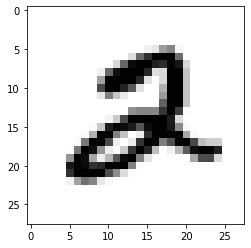

In [129]:
plt.imshow(dataset_train.data[5].detach().numpy(), cmap='binary')
plt.show()

In [151]:
#добавлю еще доп слой в модель
class LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.1):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim) #784 * 256
        self.do = nn.Dropout(dropout_p)
        self.linear2 = nn.Linear(hidden_dim, 100)
        self.activ = nn.ReLU()
        self.linear3 = nn.Linear(100, output_dim)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activ(x)
        x = self.linear2(x)
        x = self.do(x)
        x = self.activ(x)
        x = self.linear3(x)

        return x

In [152]:
# Как формируется батч
# dataloader берет из Samler набор индексов и по этим индексам получает элементы из Dataset
dataset = datasets.MNIST('.', train=True, download=True)

def collate_fn(data: list):
    # data = [(pic, target)...]
    pics = []
    targets = []
    for item in data:
        pics.append(numpy.array(item[0]))
        targets.append(item[1])
    pics = torch.from_numpy(numpy.array(pics)).float() / 255
    pics = pics.view(pics.size(0), -1) # mtx 28x28 to vec 784
    targets = torch.from_numpy(numpy.array(targets)).type(torch.LongTensor)

    return {
        'data': pics,
        'target': targets,
    }

In [153]:
#формируем загрузчик по тренировочному и тестовому набору 
dataloader_train = DataLoader(dataset_train, 
                        batch_size, 
                        shuffle=True, 
                        collate_fn=collate_fn,
                        drop_last = True)

In [154]:
dataloader_test = DataLoader(dataset_test, 
                        batch_size, 
                        shuffle=True, 
                        collate_fn=collate_fn,
                        drop_last = True)

In [155]:
#инициализируем модель
model = LinearModel(inp_dim, hidden, out_dim)
model.train() 
optim = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

In [156]:
#обучение на тренировочной 
for epoch in range(n_epochs):
    for i, batch in enumerate(dataloader_train):
        optim.zero_grad()
        predict = model(batch['data'])
        loss = loss_func(predict, batch['target'])
        loss.backward()
        optim.step()
        if i % 100 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
            
    #save every epoch
    torch.save(model.state_dict(), f'./chkpt_cv1_{epoch}.pth')

epoch: 0, step: 0, loss: 2.30100417137146
epoch: 0, step: 100, loss: 1.964905858039856
epoch: 0, step: 200, loss: 1.2235324382781982
epoch: 0, step: 300, loss: 0.9766750931739807
epoch: 0, step: 400, loss: 1.0052082538604736
epoch: 1, step: 0, loss: 0.7352019548416138
epoch: 1, step: 100, loss: 0.6033915877342224
epoch: 1, step: 200, loss: 0.6884259581565857
epoch: 1, step: 300, loss: 0.6365694403648376
epoch: 1, step: 400, loss: 0.5349210500717163
epoch: 2, step: 0, loss: 0.48190775513648987
epoch: 2, step: 100, loss: 0.4729761481285095
epoch: 2, step: 200, loss: 0.48567089438438416
epoch: 2, step: 300, loss: 0.6693612337112427
epoch: 2, step: 400, loss: 0.4612315893173218
epoch: 3, step: 0, loss: 0.5113295912742615
epoch: 3, step: 100, loss: 0.4467904269695282
epoch: 3, step: 200, loss: 0.36235031485557556
epoch: 3, step: 300, loss: 0.39515265822410583
epoch: 3, step: 400, loss: 0.4950714111328125
epoch: 4, step: 0, loss: 0.5948828458786011
epoch: 4, step: 100, loss: 0.46253028512001

In [157]:
#на тесте
for epoch in range(n_epochs):
    for i, batch in enumerate(dataloader_test):
        model.train(False)
        f_loss = 0
        predict = model(batch['data'])
        loss = loss_func(predict, batch['target'])
        f_loss +=loss
    print(f'test_loss_epoch_{epoch} = {f_loss/i}')
            
    #save every epoch
    torch.save(model.state_dict(), f'./chkpt_cv1_{epoch}.pth')

test_loss_epoch_0 = 0.0018278538482263684
test_loss_epoch_1 = 0.0019620927050709724
test_loss_epoch_2 = 0.003239627694711089
test_loss_epoch_3 = 0.0027268945705145597
test_loss_epoch_4 = 0.0025776256807148457
test_loss_epoch_5 = 0.002882803324609995
test_loss_epoch_6 = 0.0031842163298279047
test_loss_epoch_7 = 0.0026994331274181604
test_loss_epoch_8 = 0.0018634024308994412
test_loss_epoch_9 = 0.0018518964061513543


https://h1ros.github.io/posts/train-the-image-classifier-using-pytorch/
https://nestedsoftware.com/2019/08/19/pytorch-image-recognition-dense-network-3nbd.158001.html

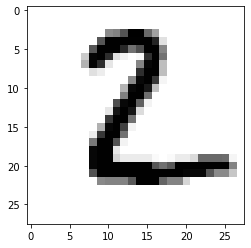

'predicted':2, 'target':2


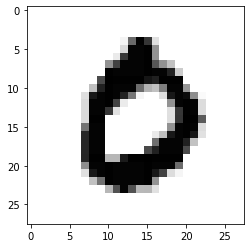

'predicted':0, 'target':0


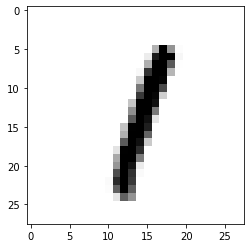

'predicted':1, 'target':1


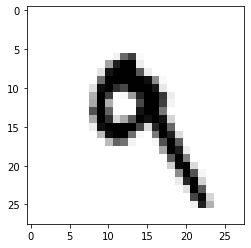

'predicted':9, 'target':9


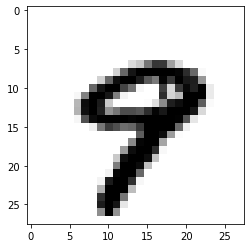

'predicted':9, 'target':9


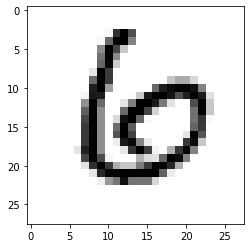

'predicted':6, 'target':6


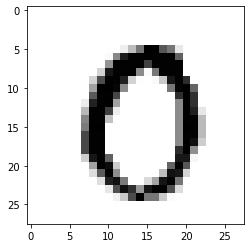

'predicted':0, 'target':0


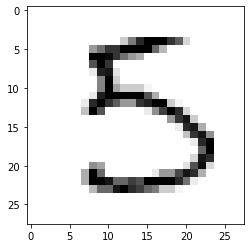

'predicted':5, 'target':5


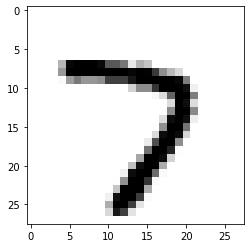

'predicted':7, 'target':7


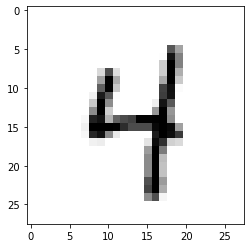

'predicted':4, 'target':4


In [158]:
#проверим модель и предскажим число
#возьмем набор чисел из тестовой выборки 
for i in range(1,20,2):
    plt.imshow(dataset_test.data[i].numpy(), cmap='binary')
    #представим в виде обычного вектора numpy
    dataset_test.data[i].numpy()
    #растянем изображение в строчку и отобразим в тензор
    d_1 = dataset_test.data[i].unsqueeze(0).view(1, -1)
    #посмотрим на метку тестового изображения 
    MNIST_target = dataset_test.targets[i]
    outputs = model(d_1.float())
    predicted = torch.argmax(outputs).squeeze().detach()
    plt.show()
    print(f"'predicted':{predicted}, 'target':{MNIST_target}")

Видно, что сетка предсказала все значения 

# Сверточная модель

In [197]:
# hyperparams
input_ch = 1
hidden_ch = 128
out_dim = 10
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 3
batch_size = 128

https://datahacker.rs/005-pytorch-convolutional-neural-network-on-mnist-in-pytorch/
https://github.com/anantgupta129/Design-a-CNN-Step-By-Step-Using-MNiST-Pytorch
https://colab.research.google.com/github/divya-r-kamat/PyTorch/blob/master/MNIST_CNN_(Fine_Tuning).ipynb
https://pytorch.org/docs/1.9.1/generated/torch.nn.Conv2d.html

In [193]:
class ConvDO(nn.Module):
    def __init__(self, input_ch, output_ch, kernel_size, stride, padding, 
                 dropout_p=0.1):
        super().__init__()
        self.conv = nn.Conv2d(
            input_ch, 
            output_ch, 
            kernel_size=kernel_size,
            stride=stride,
            padding=padding, 
        )
        # TODO добавить батч норм
        self.do = nn.Dropout(dropout_p)
        self.bn2d = nn.BatchNorm2d(output_ch)

    def forward(self, x):
        return self.do(self.bn2d(self.conv(x)))

class ConvModel(nn.Module):
    def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
        super().__init__()
        self.conv1 = ConvDO(input_ch, hidden_ch, 5, 2, 2) # уменьшим размер выходной фичматрицы в 2 раза
        # TODO еще уменьшить размер фичматрицы
        self.conv2 = ConvDO(hidden_ch, hidden_ch, 4, 1, 1)
        self.conv3 = ConvDO(hidden_ch, hidden_ch, 3, 1, 1)
        # TODO увеличить число выходных каналов
        self.conv4 = ConvDO(hidden_ch, 10, 2, 1, 1)
        self.linear = nn.Linear(
            10 * 14 * 14, # TODO поправить при изменении числа каналов и размера фич матриц
            output_dim,
        )  
        self.activ = nn.ReLU()    

    def forward(self, x):
        x = self.activ(self.conv1(x))
        x = self.activ(self.conv2(x))
        x = self.activ(self.conv3(x))
        x = self.activ(self.conv4(x))
        x = self.linear(x.view(x.size(0), -1))

        return x

In [194]:
trainloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

testloader = torch.utils.data.DataLoader(dataset_test, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

In [195]:
model_conv = ConvModel(input_ch, hidden_ch, out_dim).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.CrossEntropyLoss()

In [199]:
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()

        predict = model_conv(inputs.to(device))
        loss = loss_func(predict, labels.to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    
    
    model_conv.train()
    #save every epoch

    torch.save(model_conv.state_dict(), f'./chkpt_cv1_conv_{epoch}.pth')


epoch: 0, step: 0, loss: 0.4978879392147064
epoch: 0, step: 200, loss: 0.07146106660366058
epoch: 0, step: 400, loss: 0.07395604252815247
epoch: 1, step: 0, loss: 0.07702425122261047
epoch: 1, step: 200, loss: 0.03676433861255646
epoch: 1, step: 400, loss: 0.017362086102366447
epoch: 2, step: 0, loss: 0.04337999224662781
epoch: 2, step: 200, loss: 0.014042375609278679
epoch: 2, step: 400, loss: 0.006918954662978649


In [203]:
#на тесте
for epoch in range(n_epochs):
    for i, batch in enumerate(testloader):
        inputs, labels = batch
        model_conv.train(False)
        f_loss = 0
        predict = model_conv(inputs)
        loss = loss_func(predict, labels)
        f_loss +=loss
    print(f'test_loss_epoch_{epoch} = {f_loss/i}')
            
    #save every epoch
    torch.save(model.state_dict(), f'./chkpt_cv1_{epoch}.pth')

test_loss_epoch_0 = 0.0008559798006899655
test_loss_epoch_1 = 3.025168552994728e-05
test_loss_epoch_2 = 0.0009429075289517641


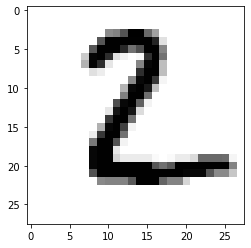

'predicted':2, 'target':2


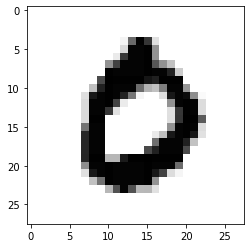

'predicted':0, 'target':0


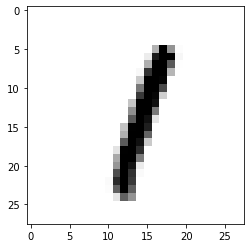

'predicted':1, 'target':1


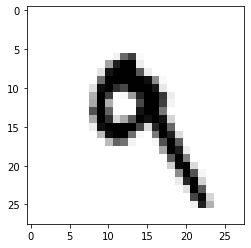

'predicted':9, 'target':9


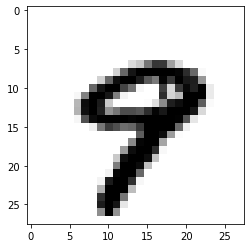

'predicted':9, 'target':9


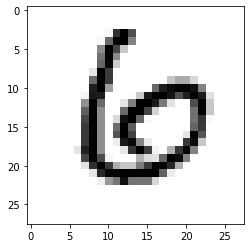

'predicted':6, 'target':6


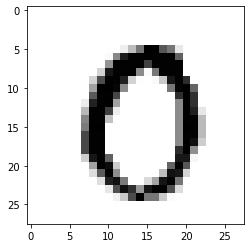

'predicted':0, 'target':0


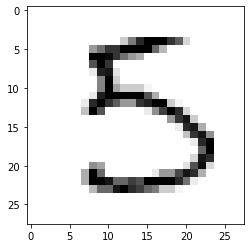

'predicted':5, 'target':5


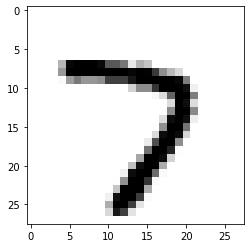

'predicted':7, 'target':7


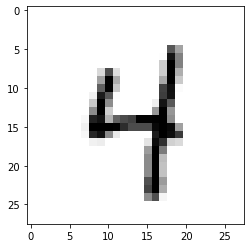

'predicted':4, 'target':4


In [205]:
#проверим модель и предскажим число
#возьмем набор чисел из тестовой выборки 
for i in range(1,20,2):
    plt.imshow(dataset_test.data[i].numpy(), cmap='binary')
    #представим в виде обычного вектора numpy
    dataset_test.data[i].numpy()
    #растянем изображение в строчку и отобразим в тензор
    d_1 = dataset_test.data[i].unsqueeze(0).unsqueeze(0)
    #посмотрим на метку тестового изображения 
    MNIST_target = dataset_test.targets[i]
    outputs = model_conv(d_1.float())
    predicted = torch.argmax(outputs).squeeze().detach()
    plt.show()
    print(f"'predicted':{predicted}, 'target':{MNIST_target}")

Cетка предсказала все значения верно